# Vehicle Detection and Tracking

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

## Histogram of Oriented Gradients (HOG)

Fist I define functions for features extraction (HOG, binned color and color histogram features). 

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

1. The **extract_features** is main feature extraction function which augment dataset by horizontal image flipping.
2. The **image_features_fun** is helper function.  

In [3]:
def image_features_fun(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,color_space='LUV'):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_HSV2RGB)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_HLS2RGB)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_YUV2RGB)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_YCrCb2RGB)
                
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each imageone by one
        image = cv2.imread(file) 
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = image_features_fun(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,color_space)
        features.append(np.concatenate(file_features))
        # Augment train data with flipped images
        feature_image=cv2.flip(feature_image,1) 
        file_features = image_features_fun(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,color_space)
        features.append(np.concatenate(file_features))
    return features 

### Load Train dataset
I use train dataset [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) provided by Udacity.

In [4]:
# Read in cars and notcars
images = glob.glob('train_data/*/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
# Balance number of images of both vehicle and non-vehicle class.
# Reduce CPU time.
#sample_size = 4000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print('Car samples have images：',len(cars))
print('Non-car sampples have images：',len(notcars))

Car samples have images： 8792
Non-car sampples have images： 8968


Here is an example of one of each of the vehicle and non-vehicle images:

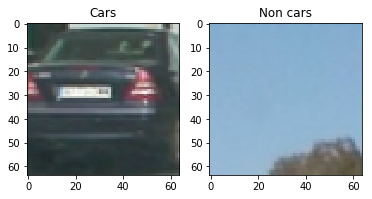

In [5]:
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.title('Cars')
plt.imshow(mpimg.imread(cars[1000]))

plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(notcars[1000]))
plt.title('Non cars')
plt.show()

### HOG feature visualization
Here is an example for HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


<function matplotlib.pyplot.show>

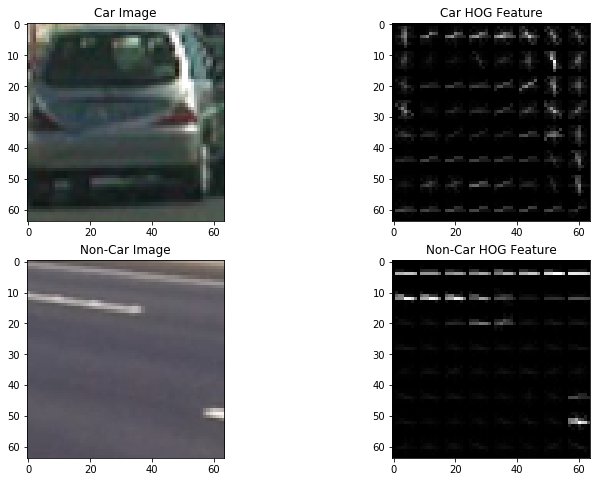

In [6]:
car_image=mpimg.imread(cars[1200])
gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(gray, 16, 8, 2,vis=True, feature_vec=True)

notcar_image=mpimg.imread(notcars[1200])
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2GRAY)
features, not_hog_image = get_hog_features(notcar_gray, 16, 8, 2,vis=True, feature_vec=True)

fig = plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image')

plt.subplot(2,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title('Car HOG Feature')
plt.show

plt.subplot(2,2,3)
plt.imshow(notcar_image, cmap='gray')
plt.title('Non-Car Image')

plt.subplot(2,2,4)
plt.imshow(not_hog_image, cmap='gray')
plt.title('Non-Car HOG Feature')
plt.show

## Explain how you settled on your final choice of HOG parameters

1. The most important for detection is speed which depends on the speed of feature extraction speed. 
So I tried several HOG parameters combination. Here we can see color space 'LUV' and hog channel 0 make fastest   extraction.
2. But after several classifier tests, we found the LUV color space and hog channel 0 made better prediction accuracy!!

In [7]:
# Define parameters for feature extraction
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


for colorspace in ('RGB','HSV','LUV','HLS','YUV','YCrCb'):
 
    for ch in (0,1,2):
        print('color space: ',colorspace,' HOG channel:',ch)
        t=time.time()   
        car_features = extract_features(cars[0:100], color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=ch, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

        notcar_features = extract_features(notcars[0:100], color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=ch, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        t2 = time.time()
        
        print(round(t2-t, 2), 'Seconds to extract featrues')

color space:  RGB  HOG channel: 0


C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.65 Seconds to extract featrues
color space:  RGB  HOG channel: 1
0.99 Seconds to extract featrues
color space:  RGB  HOG channel: 2
0.91 Seconds to extract featrues
color space:  HSV  HOG channel: 0
0.93 Seconds to extract featrues
color space:  HSV  HOG channel: 1
0.93 Seconds to extract featrues
color space:  HSV  HOG channel: 2
0.92 Seconds to extract featrues
color space:  LUV  HOG channel: 0
1.06 Seconds to extract featrues
color space:  LUV  HOG channel: 1
0.94 Seconds to extract featrues
color space:  LUV  HOG channel: 2
0.93 Seconds to extract featrues
color space:  HLS  HOG channel: 0
0.91 Seconds to extract featrues
color space:  HLS  HOG channel: 1
0.93 Seconds to extract featrues
color space:  HLS  HOG channel: 2
0.92 Seconds to extract featrues
color space:  YUV  HOG channel: 0
0.96 Seconds to extract featrues
color space:  YUV  HOG channel: 1
0.92 Seconds to extract featrues
color space:  YUV  HOG channel: 2
0.92 Seconds to extract featrues
color space:  YCrCb  HOG chan

###  Train classifier

The following code creates features for both cars and non-cars train datasets. I nomalized data features by the method **sklearn.StandardScaler()**. The data is splitted into thaining and testing subsets using **train_test_split**(80% and 20%).Then I train the classifier using linear svc and with HOG parameters : 8 orientations 8 pixels per cell and 2 cells per block.

In [8]:
# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)     

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X) 
# Apply the scaler to X
scaled_X = X_scaler.transform(X) 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) 

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('orientations:',orient)
print('pixels per cell:', pix_per_cell)
print('cells per block',cell_per_block)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()  
# Check the training time for the SVC
t=time.time() 
# Train the classifier
svc.fit(X_train, y_train) 
t2 = time.time()
print('Trainning time is:',round(t2-t, 2),' seconds')
# Test dataset model prediction accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 5)) 

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


orientations: 8
pixels per cell: 8
cells per block 2
Feature vector length: 2432
Trainning time is: 27.46  seconds
Test Accuracy of SVC =  0.98818


## Slide window

Here we define a sliding window function **slide_window** to generate a list of boxes and a **draw_boxes** to draw the  boxes on an image. The following functions are from the Udacity's lectures because they just work and have good performance.

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [10]:
def single_img_features(img, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='LUV', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Classifier test

1. Here we test the calssifier on the test images. I decided to use 128X128 sliding window size and overlap rate 0.85  to implement **slide_window** function after several experiments .
2. We can see that the speed is a little slow.

C:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time of process test images:  2.02  seconds.
Time of process test images:  1.19  seconds.
Time of process test images:  0.99  seconds.
Time of process test images:  1.01  seconds.
Time of process test images:  1.08  seconds.
Time of process test images:  1.0  seconds.
Time of process test images:  1.11  seconds.


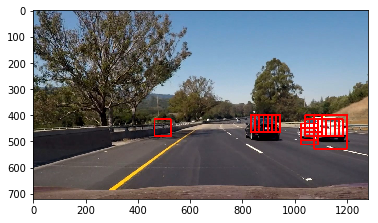

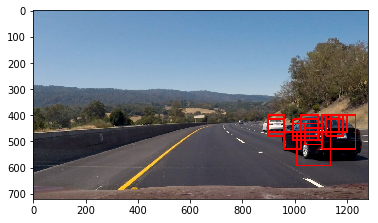

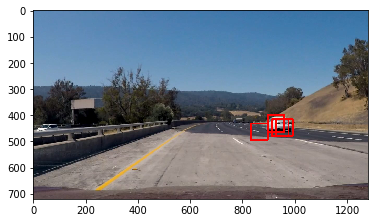

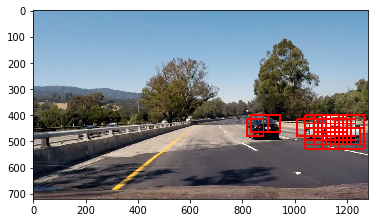

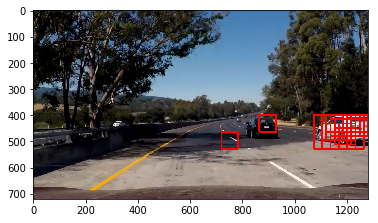

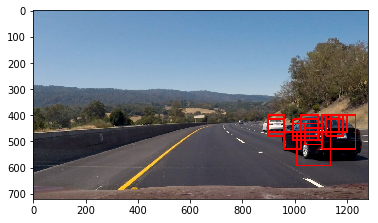

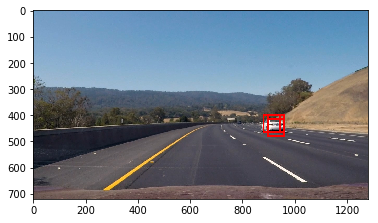

In [12]:
# A function to show an image
def show_img(img):
    #if read image using cv2.imread
    if len(img.shape)==3: 
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')
        

for image_p in glob.glob('test_images/test*.jpg'):
    t=time.time() # Start time
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    # Here we define a specific range area for test
    windows = slide_window(image, x_start_stop=[880, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[0, 400], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[400, 1280], y_start_stop=[400, 550], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    print('Time of process test images: ',round(time.time()-t, 2),' seconds.')
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)
    

## Improved Sliding Window
To increase the performance of detection,we must decide the smallest windows and searching areas.So we only scan some parts of image where the cars will show up. 
### ROI settings
We find new cars which in the red boxes area and far cars which in green boxes area.

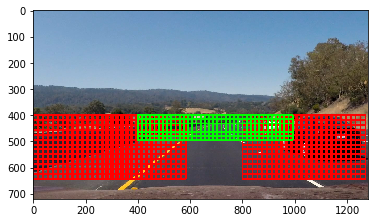

In [13]:
image = cv2.imread('test_images/test6.jpg')
windows = slide_window(image, x_start_stop=[800, 1280], y_start_stop=[400, 650], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
windows += slide_window(image, x_start_stop=[0, 600], y_start_stop=[400, 650], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
windows = slide_window(image, x_start_stop=[400, 1000], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(0, 255, 0), thick=6)                    
show_img(window_img)

#### Advanced Lane line function

Here we load lane finding function from the [Advanced Lane lines](https://github.com/wuqianliang/ND013/tree/master/advanced%20lane%20finding).

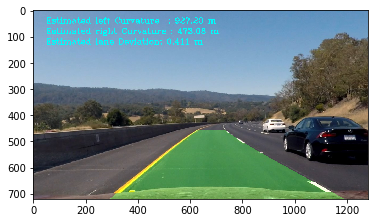

In [14]:
from Advanced_Lane_Finding  import *
line=Line()
show_img(line.image_process_pipeline(cv2.imread('test_images/test6.jpg')))


## Multiple Detections & False Positives

### Hog Sub-sampling Window Search
In order to detect several deferent size and position of cars in images and **speed up** the detection process, we define a function **find_cars()** to generate windows with cars in it by a specific scale such that we could run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [15]:
def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def find_cars(img, ystart, ystop, xstart, xstop, scale, step, 
              svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2, spatial_size=(16, 16), hist_bins=32,_window=64):
    boxes = []
    draw_img = np.zeros_like(img)   
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale))) 
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    #print('nfeat_per_block:',nfeat_per_block)
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = _window
    nblocks_per_window = (window // pix_per_cell) -1
    #print('nblocks_per_window:',nblocks_per_window)
    # Instead of overlap, define how many cells to step
    cells_per_step = step  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

### Remove False Positives
1. Here we define heatmap filtering functions suggested by lectures to remove false positive boxes. We filter all found windows by a heatmap threshhold.
2. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

In [16]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Tests of filter for false positives and some method for combining overlapping bounding boxes.

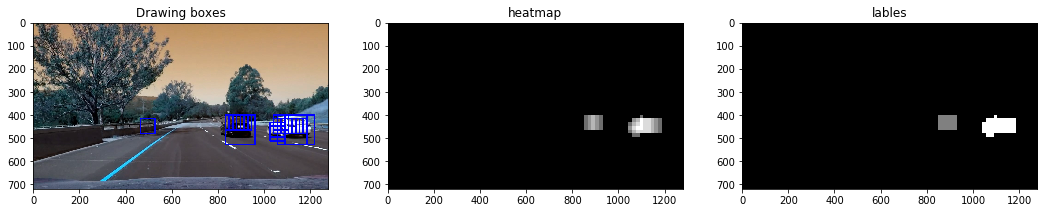

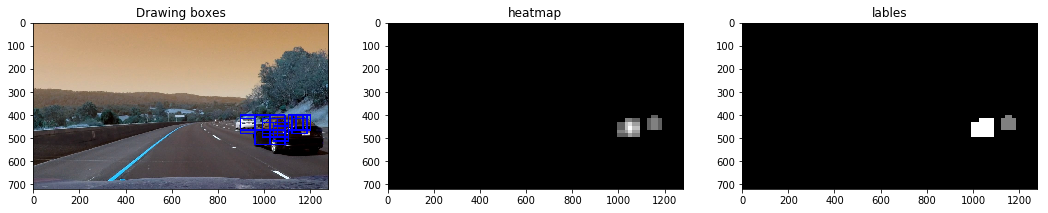

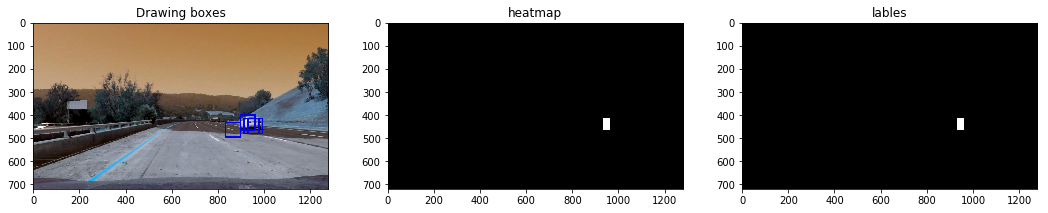

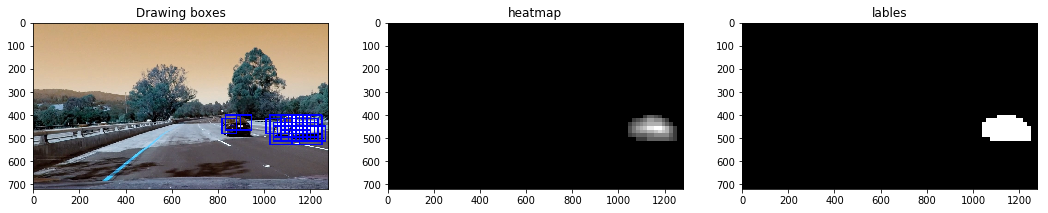

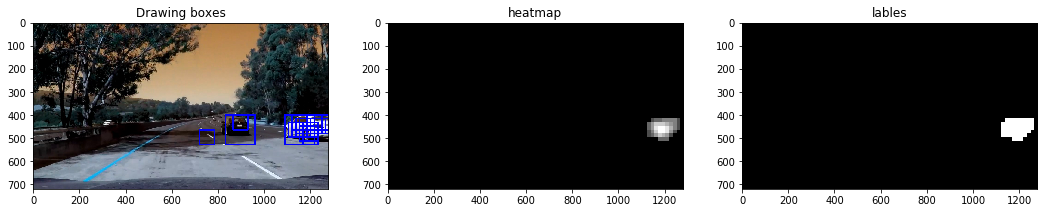

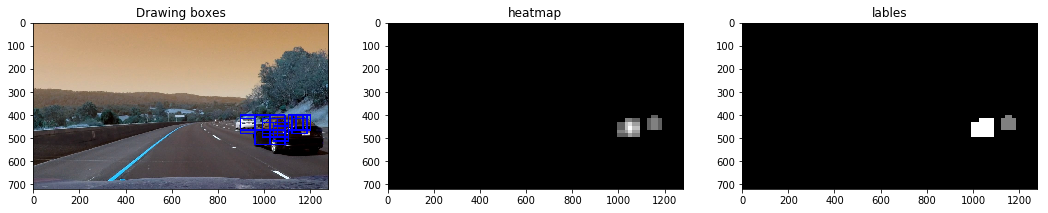

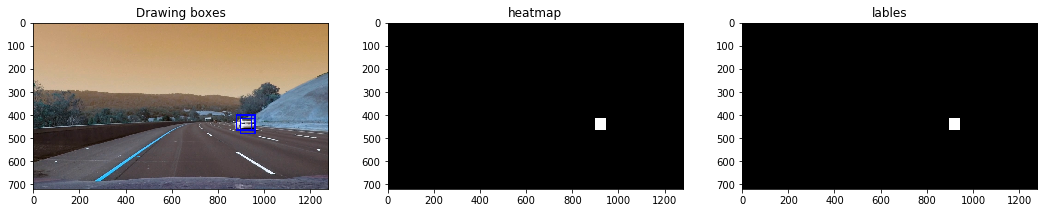

In [24]:
for file in glob.glob('test_images/test*.jpg'):
    t=time.time() # Start time
    image = cv2.imread(file)
    
    img = np.copy(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Here we define a specific range area for test
    windows = slide_window(img, x_start_stop=[800, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, x_start_stop=[0, 400], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, x_start_stop=[400, 1280], y_start_stop=[400, 550], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    #print('Time of process test images: ',round(time.time()-t, 2),' seconds.')
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    fig = plt.figure(figsize=(18,10))
    plt.subplot(1,3,1)
    plt.imshow(window_img, cmap='gray')
    plt.title('Drawing boxes')
    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap='gray')
    plt.title('heatmap')
    plt.subplot(1,3,3)
    plt.imshow(labels[0], cmap='gray')
    plt.title('lables')
    plt.show()

## Detection and tracking process pipeline

In [19]:
def image_process_pipeline(image):
    
    img = np.copy(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    boxes = []
        
    '''
    # Here is the working sliding window tech, but very slow when process video 
    if True:
        # Use sliding windows in ROI area
        windows = slide_window(image, x_start_stop=[880, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
        windows += slide_window(image, x_start_stop=[0, 400], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
        
        windows += slide_window(img, x_start_stop=[400, 1280], y_start_stop=[350, 650], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
        boxes += (search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    '''
    if True:
        # Right side 
        boxes = find_cars(img, 400, 650, 800, 1280, 2.5, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes += find_cars(img, 400, 500, 800, 1280, 1, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # Left side
        boxes += find_cars(img, 400, 650, 0, 400, 2.5, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes += find_cars(img, 400, 500, 0, 400, 1, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        # For far cars
        boxes += find_cars(img, 350, 400, 400, 800, 0.75, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
     
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    # Debug boxes
    #draw_img = draw_boxes(draw_img, boxes, color=(0, 255, 0), thick=4)
    
    return cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)

#### Example of video process pipeline:
1. Undistort image and draw lane line
2. Detect cars and get process time which is more fast than the previous sliding window tech

Time of process test images:  0.38  seconds.
Time of process test images:  0.38  seconds.
Time of process test images:  0.43  seconds.
Time of process test images:  0.37  seconds.
Time of process test images:  0.37  seconds.
Time of process test images:  0.43  seconds.
Time of process test images:  0.37  seconds.


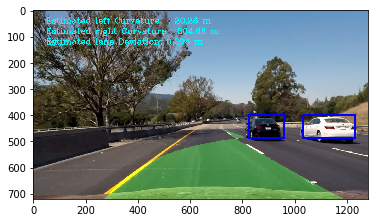

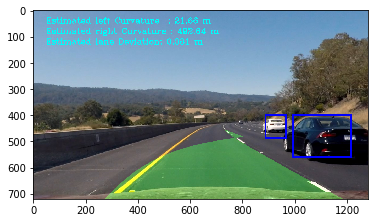

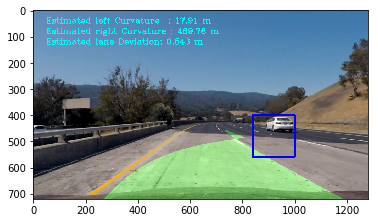

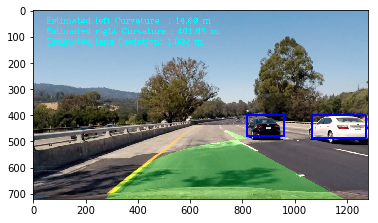

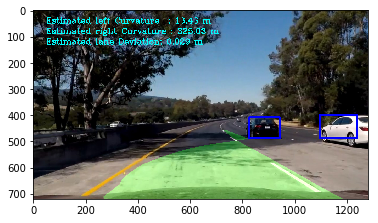

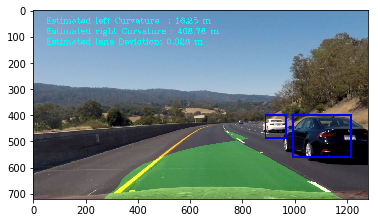

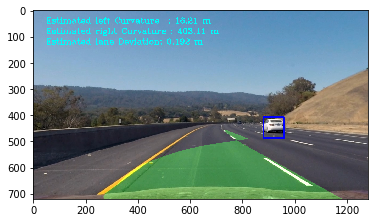

In [21]:
for ima in glob.glob('test_images/test*.jpg'):
    image1 = cv2.imread(ima)
    
    image2 = line.image_process_pipeline(image1)
    image3 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    t=time.time() # Start time
    show_img(image_process_pipeline(image3))
    print('Time of process test images: ',round(time.time()-t, 2),' seconds.')

## Video processing

Here we process the test_video.mp4 and project_video.mp4 using VideoFileClip.

In [22]:
from moviepy.editor import VideoFileClip
from object_detect_yolo import YoloDetector
def process_image(image):
 
    t=time.time() # Start time
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image2 = line.image_process_pipeline(image)
    image3 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    return cv2.cvtColor(image_process_pipeline(image3), cv2.COLOR_BGR2RGB)
    print('Time of process test images: ',round(time.time()-t, 2),' seconds.')

output_v = 'processed_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video processed_test_video.mp4
[MoviePy] Writing video processed_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:23<00:00,  1.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_test_video.mp4 

Wall time: 25.2 s


In [23]:
output_v = 'processed_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [18:47<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

Wall time: 18min 49s
